# LMC 3D structure

Luis,Angel,Xavi,Hector,Alfred,Roger...y viceversa :)

## Generación de Simulaciones

In [1]:
#######################
#### Load packages ####
#######################


from __future__ import absolute_import, division, print_function, unicode_literals
import functools
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
# import warnings
import json
import sys
import numpy as np
# import csv
#import seaborn as sns
import pandas as pd
import time
#import arviz as az  # https://arviz-devs.github.io/arviz/index.html

#%tensorflow_version 2.x
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

 
import tensorflow_probability as tfp
#import matplotlib
#import matplotlib.pyplot as plt
#matplotlib.use('Agg')
tfd = tfp.distributions
tfb = tfp.bijectors

from tensorflow.python.ops import math_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import gen_math_ops


Tensorflow version 2.2.0


### Working with Tensor Flow

In [2]:
###################
#### Functions ####
###################

def proper2geo_fnt(xyz,distCenterLMC,alphaCenterLMC,deltaCenterLMC,
                      posAngleLMC,inclAngleLMC):
 
# Transform samples of location coordinates in the proper frame of the LMC
# to the rectangular heliocentric frame
#
# References:
#  Van der Marel & Cioni (2001)
#  Weinberg and Nikolaev (2001)
# 
# Parameters: 
# -xyz                 A tensor of shape=(N, 3) containing N samples in the
#                     proper LMC frame 
# -N                   No of samples
# -distCenterLMC       Distance to the LMC centre (kpc)
# -alphaCenterLMC      RA of the LMC centre (rad)
# -deltaCenterLMC      Dec of the LMC centre (rad)
# -posAngleLMC         Position angle of the LON measured w.r.t. the North (rad)
# -inclAngleLMC        Inclination angle (rad)
#
# Return:             A tensor of shape=(N, 3) containing N samples of rectangular 
#                    coordinates in the heliocentric frame                 
 


    # Affine transformation from local LMC frame to heliocentric frame 

    s11 = tf.sin(alphaCenterLMC)
    s12 = -tf.cos(alphaCenterLMC) * tf.sin(deltaCenterLMC)
    s13 = -tf.cos(alphaCenterLMC) * tf.cos(deltaCenterLMC)
    s21 = -tf.cos(alphaCenterLMC)
    s22 = -tf.sin(alphaCenterLMC) * tf.sin(deltaCenterLMC)
    s23 = -tf.sin(alphaCenterLMC) * tf.cos(deltaCenterLMC)
    s31 = tf.zeros([])
    s32 = tf.cos(deltaCenterLMC)
    s33 = -tf.sin(deltaCenterLMC)
 
    matrix = tf.stack((s11,s12,s13,s21,s22,s23,s31,s32,s33),
                      axis=-1)  # pyformat: disable
    output_shape = tf.concat((
        tf.shape(input=tf.zeros(4))[:-1], (3, 3)), axis=-1)

    OXYZ2 = tf.reshape(matrix, shape=output_shape)

    
    LMC_center = tf.stack(
        [
            distCenterLMC *
            tf.cos(deltaCenterLMC) *
            tf.cos(alphaCenterLMC),   
            distCenterLMC *
            tf.cos(deltaCenterLMC) *
            tf.sin(alphaCenterLMC),
            distCenterLMC *
            tf.sin(deltaCenterLMC)
        ], axis=0)


    S1_ = tf.linalg.LinearOperatorFullMatrix(OXYZ2)
    S1_ALO = tfb.AffineLinearOperator(shift=LMC_center, scale=S1_)

     
    # Linear transformation from proper to local LMC frame 
 
    
    s11 = tf.cos(posAngleLMC)  
    s12 = -tf.sin(posAngleLMC) * tf.cos(inclAngleLMC)  
    s13 = -tf.sin(posAngleLMC) * tf.sin(inclAngleLMC)
    s21 = tf.sin(posAngleLMC)  
    s22 = tf.cos(posAngleLMC) * tf.cos(inclAngleLMC)  
    s23 = tf.cos(posAngleLMC) * tf.sin(inclAngleLMC)  
    s31 = tf.zeros([])  
    s32 = -tf.sin(inclAngleLMC)  
    s33 = tf.cos(inclAngleLMC)  
     
 
    matrix2 = tf.stack((s11,s12,s13,s21,s22,s23,s31,s32,s33),
                      axis=-1)  # pyformat: disable
    output_shape = tf.concat((
        tf.shape(input=tf.zeros(4))[:-1], (3, 3)), axis=-1)

    OXYZ5 = tf.reshape(matrix2, shape=output_shape)
    
    #print("OXYZ5.shape",OXYZ5.shape)

    S2_ = tf.linalg.LinearOperatorFullMatrix(OXYZ5)
    #print("Shape_S2",S2_.shape)
    S2_ALO = tfb.AffineLinearOperator(shift=tf.zeros(3), scale=S2_)
    #print("Shape_S2",S2_.shape)

    chain = tfb.Chain([  S1_ALO,  S2_ALO])
    #print("chain.shape",chain.shape)
    output0=chain._forward( xyz, axis=1) 
    #print("output0=",output0.shape)
    return output0

 

def disk_fnt(n, scaleHeight, scaleLength, psiAngle, ellFactor):
 
# Generate samples of location coordinates of the LMC disk in a proper  
# reference frame and transform them to a proper LMC reference frame 
# References:
#  Mancini et al. (2004)
#
# Parameters: 
# -N                   No of samples
# -scaleHeight         Disk scale height (kpc)
# -scaleLength         Disk scale length (kpc)
# -ellFactor           Disk ellipticity factor. For a circular disk set = 1                                                  
# -psiAngle            Disk minor axis position angle measured w.r.t. LON (rad)
#                     For a circular disk set = 0
#
# Return:             A tensor of shape=(n, 3) containing N samples of the   
#                    star locations in a local LMC reference frame                
 

    s11 =  tf.cos(psiAngle) 
    s12 = -tf.sin(psiAngle)   
    s13 = tf.zeros([])
    s21 =  tf.sin(psiAngle)
    s22 =  tf.cos(psiAngle)  
    s23 = tf.zeros([])
    s31 = tf.zeros([])  
    s32 = tf.zeros([])  
    s33 = tf.ones([])
 
    matrix = tf.stack((s11,s12,s13,s21,s22,s23,s31,s32,s33),
                      axis=-1)  # pyformat: disable
    #print("matrix",matrix)
    output_shape = tf.concat((
        tf.shape(input=tf.zeros(4))[:-1], (3, 3)), axis=-1)

    OXYZ6 = tf.reshape(matrix, shape=output_shape)
    
    #print(OXYZ6.shape)

    S3_ = tf.linalg.LinearOperatorFullMatrix(OXYZ6)
    S3_ALO = tfb.AffineLinearOperator(shift=tf.zeros(3), scale=S3_)
    
    r = tfd.Gamma(concentration=2, rate=1./scaleLength).sample(n )
    theta = tfd.Uniform(low=0., high=2.*np.pi).sample(n )

    x = ellFactor * r * tf.cos(theta)
    y = r * tf.sin(theta)

    z = tfd.Laplace(loc=0., scale=scaleHeight).sample(n )

    chain = tfb.Chain([  S3_ALO ])
    
    output1= chain._forward(tf.stack([x, y, z], axis=1))
    #print("Shape",output1.shape)
    return output1

def geo2plx_fnt( x  ):
# Transform rectangular heliocentric coordinates to (ra,dec,parallax) coordinates

        x0 = x[..., 0]
        x1 = x[..., 1]
        x2 = x[..., 2]
        y0 = array_ops.where(
                gen_math_ops.greater(x1, 0.0),
                math_ops.scalar_mul(180.0/np.pi, math_ops.atan2(x1, x0)),
                math_ops.scalar_mul(180.0/np.pi, math_ops.atan2(x1, x0)) + 360.0)
        #print(y0)
        y2 = 1./math_ops.sqrt(
                math_ops.reduce_sum(math_ops.multiply(x, x), axis=1))

        # y2 = tf.linalg.norm(x, axis=1)
        y1 = math_ops.scalar_mul(180.0/np.pi, math_ops.asin(x2/(1./y2)))
        #print(y1)
        output2=array_ops.stack([y0, y1, y2], axis=1)
        #print("output2",output2.shape)
        return output2

 

def measurements_fnt(x , raErrorMean, raErrorVar , decErrorMean, 
                    decErrorVar, plxErrorMean, plxErrorVar ): 
    
    n =  x.numpy().shape[0]

    raErrorShape  = (raErrorMean ** 2)/raErrorVar
    raErrorScale  = raErrorVar/raErrorMean 

    decErrorShape  = (decErrorMean ** 2)/decErrorVar
    decErrorScale  = decErrorVar/decErrorMean 

    plxErrorShape  = (plxErrorMean ** 2)/plxErrorVar
    plxErrorScale  = plxErrorVar/plxErrorMean 

    ra_error = tfd.Gamma(concentration=raErrorShape, 
                         rate=1./raErrorScale).sample(n )
    
    dec_error = tfd.Gamma(concentration=decErrorShape, 
                          rate=1./decErrorScale).sample(n )
    
    plx_error = tfd.Gamma(concentration=plxErrorShape, 
                          rate=1./plxErrorScale).sample(n )

    x0 = x[..., 0]
    x1 = x[..., 1]
    x2 = x[..., 2]

    uncs = array_ops.stack([ra_error, dec_error, plx_error], axis=1)

    

    obs =  tfd.MultivariateNormalDiag(loc=x,
                                      scale_diag=uncs).sample(1) 

    return obs, uncs 
     

 



In [3]:
####################################
### Generate synthetic catalogue ###
####################################

# LMC fixed hyperparameters
dist_centre_lmc=50. 
alpha_centre_lmc=80.8939*np.pi/180. 
delta_centre_lmc=-69.7561*np.pi/180.
pos_angle_lmc=(122.5 + 90.)*np.pi/180.
inc_angle_lmc=34.7*np.pi/180. 

# Disk component fixed hyperparameters
disk_scale_height = 0.35
disk_scale_length = 1.6
pos_angle_disk = 202.7*np.pi/180
ell_factor_disk = 0.688 

# Uncertainty on measurements roughly estimated from the catalogue
ra_error_mean   = 0.1711426
ra_error_var = 0.006506719

dec_error_mean    =  0.1804739
dec_error_var = 0.007289793 

plx_error_mean  =  0.1758596
plx_error_var = 0.006775405 


# Set No of samples we want to generate
N = 50000000

# Generate disk location coordinates in the LMC proper reference frame
xyz_propert = disk_fnt(N, disk_scale_height, disk_scale_length, 
                     pos_angle_disk - pos_angle_lmc, ell_factor_disk)

# Transform from proper to heliocentric frame
xyz_geot =  proper2geo_fnt(xyz_propert, dist_centre_lmc, alpha_centre_lmc,
                         delta_centre_lmc, pos_angle_lmc, inc_angle_lmc )

# Generate (ra,dec,plx) true values

cyl_plxt  =   geo2plx_fnt(xyz_geot)

# Generate (ra,dec,plx) measurements & uncertainties

#measurements_fn(cyl_plx , ra_error_mean, ra_error_var , 
#                dec_error_mean, dec_error_var,  plx_error_mean, plx_error_var )  




simu=np.array(cyl_plxt)

Instructions for updating:
`AffineLinearOperator` bijector is deprecated; please use `tfb.Shift(loc)(tfb.ScaleMatvecLinearOperator(...))`.


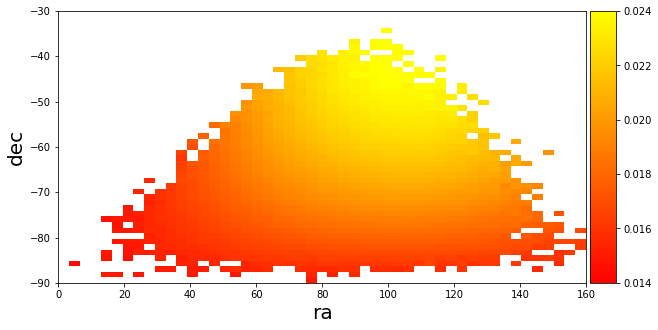

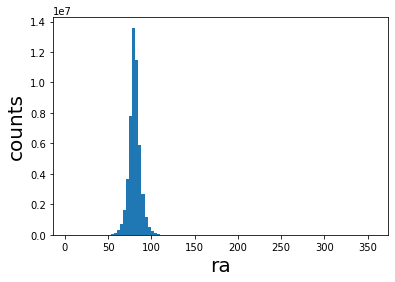

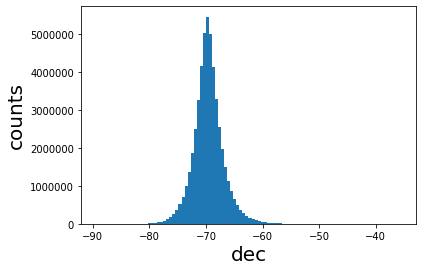

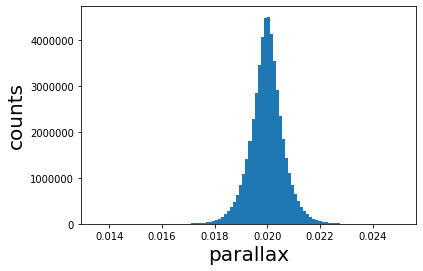

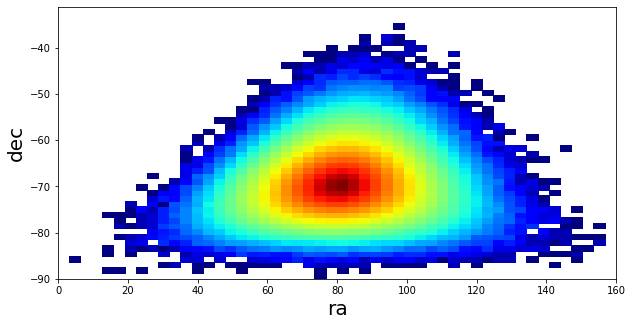

In [4]:
ra=simu[:,0]
dec=simu[:,1]
parallax=simu[:,2]
bins1=np.arange(0,160,160/50)
bins2=np.arange(-90,-30,60/50)
ret=stats.binned_statistic_2d(ra, dec, parallax, statistic='mean', bins=[bins1,bins2], range=None, expand_binnumbers=False)

meant=ret.statistic

xedges=ret.x_edge

yedges=ret.y_edge

plt.figure(figsize=(10,5))
im=plt.imshow(meant.T, aspect='auto',interpolation="nearest", origin="upper",cmap='autumn',extent=[0, 160, -30, -90],vmin=0.014,vmax=0.024)
ax = plt.gca()
ax.invert_yaxis()
#plt.gca().invert_xaxis()
plt.xlabel("ra",fontsize=20)
plt.ylabel("dec",fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

plt.hist(ra,bins=100)
plt.xlabel("ra",fontsize=20)
plt.ylabel("counts",fontsize=20)
plt.show()
plt.hist(dec,bins=100)
plt.xlabel("dec",fontsize=20)
plt.ylabel("counts",fontsize=20)
plt.show()
plt.hist(parallax,bins=100)
plt.xlabel("parallax",fontsize=20)
plt.ylabel("counts",fontsize=20)
plt.show()


plt.figure(figsize=(10,5))

plt.hist2d(ra,dec,bins=[bins1,bins2],cmap='jet',norm=LogNorm())
plt.xlim(0,160)
plt.xlabel("ra",fontsize=20)
plt.ylabel("dec",fontsize=20)
#plt.gca().invert_xaxis()
plt.show()

## Working wiht numpy

# Function 1: disk_fn

Following Mancini et al. (2004) In this function we generate the disk of the LMC in a given set of coordinates $\xi$,$\eta$,$\zeta \equiv z'$. To transform x',y',z' reference frame to $\xi$,$\eta$,$\zeta \equiv z'$ is needed rotate it by an angle ($\Phi-\Theta-\pi/2$).  If I understoo correct we want to go on the other way around from  $\xi$,$\eta$,$\zeta \equiv z'$ to x',y',z' then:

$$
\left(\begin{array}{c} 
x' \\
y' \\
z' \\
\end{array}\right)=
\left(\begin{array}{ccc} 
cos(\Phi-\Theta-\pi/2) & -sin(\Phi-\Theta-\pi/2) & 0\\
sin(\Phi-\Theta-\pi/2) & cos(\Phi-\Theta-\pi/2) & 0\\
0 &0 &1
\end{array}\right)^T
\left(\begin{array}{c} 
\xi\\
\eta \\
\zeta\\
\end{array}\right)
$$ 

Literal from Mancini et al. (2004):

"The Cartesian coordinates ($\xi$,$\eta$,$\zeta \equiv z'$) are obtained from
the system (x', y', z') by rotation around the z'-axis by an angle
equal to ($\Phi-\Theta-\pi/2$), where \Phi is the position angle of the LMC
disk major axis. In this way the \xi − \eta plane coincides with the
equatorial disk plane and the η axis is directed along the major
axis of the elliptic disk"

"the (x', y')
plane coincides with the equatorial plane of the LMC galaxy,
and the x'-axis is along the line of nodes."




In [5]:
###################
#### Functions ####
###################



def disk_fn(n, scaleHeight, scaleLength, psiAngle, ellFactor):
 
# Generate samples of location coordinates of the LMC disk in a proper  
# reference frame and transform them to a proper LMC reference frame 
# References:
#  Mancini et al. (2004)
#
# Parameters: 
# -N                   No of samples
# -scaleHeight         Disk scale height (kpc)
# -scaleLength         Disk scale length (kpc)
# -ellFactor           Disk ellipticity factor. For a circular disk set = 1                                                  
# -psiAngle            Disk minor axis position angle measured w.r.t. LON (rad)
#                     For a circular disk set = 0
#
# Return:             A tensor of shape=(n, 3) containing N samples of the   
#                    star locations in a local LMC reference frame                
 

    s11 =  np.cos(psiAngle) 
    s12 = -np.sin(psiAngle)   
    s13 = np.zeros([])
    s21 =  np.sin(psiAngle)
    s22 =  np.cos(psiAngle)  
    s23 = np.zeros([])
    s31 = np.zeros([])  
    s32 = np.zeros([])  
    s33 = np.ones([])
 
    matrix = np.stack((s11,s12,s13,s21,s22,s23,s31,s32,s33),
                      axis=-1)  # pyformat: disable
    output_shape = np.concatenate((
        np.shape(np.zeros(4))[:-1], (3, 3)), axis=-1)

    OXYZ6 = np.reshape(matrix, output_shape.astype(int))

    #S3_ = tf.linalg.LinearOperatorFullMatrix(OXYZ6)
    #S3_ALO = tfb.AffineLinearOperator(shift=tf.zeros(3), scale=S3_)
    
    #r = tfd.Gamma(concentration=2, rate=1./scaleLength).sample(n )
    r = np.random.gamma(shape = 2,scale = scaleLength, size = n)
    theta = np.random.uniform(low=0., high=2.*np.pi, size = n)

    xi = ellFactor * r * np.cos(theta)
    eta = r * np.sin(theta)

    zeta = np.random.laplace(loc=0., scale=scaleHeight, size=n )

    #chain = tfb.Chain([  S3_ALO ])
    
    #output1n=np.stack([x,y,z],axis=1).dot(OXYZ6)
    output1n=(OXYZ6.T).dot(np.stack([xi,eta,zeta],axis=1).T).T # As far as I understund OXYZ6 should be transponded
    print("mat11",output1n.shape)
    #mat1 = np.matmul(OXYZ6,np.stack([x,y,z],axis=1)) + np.zeros(3)

    return output1n

# Function 2: proper2geo_fn


"We introduce also a
cartesian coordinate system (x, y, z) that has its origin O in the
center of the LMC, whose coordinates are ($\alpha_0$, $\delta_0$, $D_0$), with
the x-axis antiparallel to the right ascension axis, the y-axis parallel to the declination axis, and the z-axis pointing towards the observer."

If I understand correctly the transformation from x',y',x' to x,y,z is given by Van der Mareel 2002 equation 4:

$$
\left(\begin{array}{c} 
x \\
y \\
z \\
\end{array}\right)=
\left(\begin{array}{ccc} 
cos(\theta) & -sin(\theta)cos(i) & -sin(\theta)sin(i)\\
sin(\theta) & cos(\theta)cos(i) &sin(\theta)sin(i)\\
0 &-sin(i) &cos(i)
\end{array}\right)
\left(\begin{array}{c} 
x'\\
z' \\
y'\\
\end{array}\right)
$$ 

Now to go from the x,y,z reference fraim to the heliocentric:





In [6]:
def proper2geo_fn(xyz,distCenterLMC,alphaCenterLMC,deltaCenterLMC,
                      posAngleLMC,inclAngleLMC):
 
# Transform samples of location coordinates in the proper frame of the LMC
# to the rectangular heliocentric frame
#
# References:
#  Van der Marel & Cioni (2001)
#  Weinberg and Nikolaev (2001)
# 
# Parameters: 
# -xyz                 A tensor of shape=(N, 3) containing N samples in the
#                     proper LMC frame 
# -N                   No of samples
# -distCenterLMC       Distance to the LMC centre (kpc)
# -alphaCenterLMC      RA of the LMC centre (rad)
# -deltaCenterLMC      Dec of the LMC centre (rad)
# -posAngleLMC         Position angle of the LON measured w.r.t. the North (rad)
# -inclAngleLMC        Inclination angle (rad)
#
# Return:             A tensor of shape=(N, 3) containing N samples of rectangular 
#                    coordinates in the heliocentric frame                 
 


    # Affine transformation from local LMC frame to heliocentric frame 

    s11 = np.sin(alphaCenterLMC)
    s12 = -np.cos(alphaCenterLMC) * np.sin(deltaCenterLMC)
    s13 = -np.cos(alphaCenterLMC) * np.cos(deltaCenterLMC)
    s21 = -np.cos(alphaCenterLMC)
    s22 = -np.sin(alphaCenterLMC) * np.sin(deltaCenterLMC)
    s23 = -np.sin(alphaCenterLMC) * np.cos(deltaCenterLMC)
    s31 = np.zeros([])
    s32 = np.cos(deltaCenterLMC)
    s33 = -np.sin(deltaCenterLMC)
    
    
 
    matrix = np.stack((s11,s12,s13,s21,s22,s23,s31,s32,s33),
                      axis=-1)  # pyformat: disable
    output_shape = np.concatenate((
        np.shape(np.zeros(4))[:-1], (3, 3)), axis=-1)

    OXYZ2 = np.reshape(matrix, output_shape.astype(int))

    
    LMC_center = np.stack(
        [
            distCenterLMC *
            np.cos(deltaCenterLMC) *
            np.cos(alphaCenterLMC),   
            distCenterLMC *
            np.cos(deltaCenterLMC) *
            np.sin(alphaCenterLMC),
            distCenterLMC *
            np.sin(deltaCenterLMC)
        ], axis=0)

    #print("LMC_center",LMC_center)
     
    # Linear transformation from proper to local LMC frame 
 
    
    s11 = np.cos(posAngleLMC)  
    s12 = -np.sin(posAngleLMC) * np.cos(inclAngleLMC)  
    s13 = -np.sin(posAngleLMC) * np.sin(inclAngleLMC)
    s21 = np.sin(posAngleLMC)  
    s22 = np.cos(posAngleLMC) * np.cos(inclAngleLMC)  
    s23 = np.cos(posAngleLMC) * np.sin(inclAngleLMC)  
    s31 = np.zeros([])  
    s32 = -np.sin(inclAngleLMC)  
    s33 = np.cos(inclAngleLMC)  
     
 
    matrix2 = np.stack((s11,s12,s13,s21,s22,s23,s31,s32,s33),
                      axis=-1)  # pyformat: disable
    output_shape = np.concatenate((
        np.shape(np.zeros(4))[:-1], (3, 3)), axis=-1)
    #global mat1
    OXYZ5 = np.reshape(matrix2, output_shape.astype(int))
 
    #mat1=xyz.dot(OXYZ5)
    mat1=OXYZ5.dot(xyz.T)
    plt.figure(figsize=(10,5))
    plt.hist2d(mat1[0],mat1[1],100,cmap='jet',norm=LogNorm())
#plt.xlim(-10,15)
#plt.ylim(10,24)
    plt.show() 
    #print(mat1)
    #print("mat1",mat1.shape)
    #print(OXYZ2.shape)
    #output0n=mat1.dot(OXYZ2) + np.array(LMC_center)
    output0n=(OXYZ2).dot(mat1).T + np.array(LMC_center)
    #print("output0n",output0n)
    #mat1 = np.matmul(OXYZ5,xyz) + np.zeros(3)
    #mat2 = np.matmul(OXYZ2,mat1) + LMC_center
    
    return output0n

 



def geo2plx_fn( x  ):
# Transform rectangular heliocentric coordinates to (ra,dec,parallax) coordinates

        x0 = x[..., 0]
        x1 = x[..., 1]
        x2 = x[..., 2]
        y0 = np.array([])
        #for element in range(len(x1)):
        #    if x1[element] > 0.:
        #        y0 = np.append(y0,np.dot(180./np.pi,np.arctan2(x1[element],x0[element])))
        #    else:
        #        y0 = np.append(y0,np.dot(180./np.pi,np.arctan2(x1[element],x0[element]))+360.)
                
                
        #y0 = np.where(x1>0,np.dot(180.0/np.pi,np.arctan2(x1,x0)),np.dot(180.0/np.pi,np.arctan2(x1,x0))+360.)
        y0 = np.where(x1>0,180.0/np.pi*np.arctan2(x1,x0),180.0/np.pi*np.arctan2(x1,x0)+360.) # ra
        
        #print(y0)     
        y2 = 1./np.sqrt(np.sum(np.multiply(x, x), axis=1)) # parallax ok
        #print(y2)
        # y2 = tf.linalg.norm(x, axis=1)
        y1 = np.dot(180.0/np.pi, np.arcsin(x2/(1./y2))) #dec
        #print(y1)
        
        output2n=np.stack([y0, y1, y2], axis=1)
        return output2n

 

def measurements_fn(x , raErrorMean, raErrorVar , decErrorMean, 
                    decErrorVar, plxErrorMean, plxErrorVar ): 
    
    n =  x.shape[0]

    raErrorShape  = (raErrorMean ** 2)/raErrorVar
    raErrorScale  = raErrorVar/raErrorMean 

    decErrorShape  = (decErrorMean ** 2)/decErrorVar
    decErrorScale  = decErrorVar/decErrorMean 

    plxErrorShape  = (plxErrorMean ** 2)/plxErrorVar
    plxErrorScale  = plxErrorVar/plxErrorMean 

    ra_error = np.random.gamma(shape=raErrorShape, 
                         scale=raErrorScale,size=n )
    
    dec_error = np.random.gamma(shape=decErrorShape, 
                          scale=decErrorScale,size=n )
    
    plx_error = np.random.gamma(shape=plxErrorShape, 
                          scale=plxErrorScale,size=n )

    x0 = x[..., 0]
    x1 = x[..., 1]
    x2 = x[..., 2]

    uncs = np.stack([ra_error, dec_error, plx_error], axis=1)

    

    obs =  np.random.multivariate_normal(mean=x,
                                      cov=uncs,size=1) 

    return obs, uncs 

     

 

# Generación de un primer catalogo sintetico sin errores

mat11 (50000000, 3)


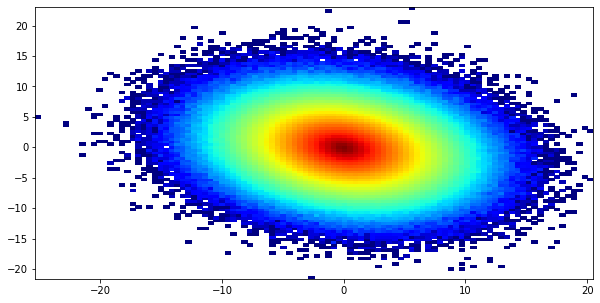

In [7]:
####################################
### Generate synthetic catalogue ###
####################################

# LMC fixed hyperparameters
dist_centre_lmc=50. 
alpha_centre_lmc=80.8939*np.pi/180. 
delta_centre_lmc=-69.7561*np.pi/180.
pos_angle_lmc=(122.5 + 90.)*np.pi/180.
inc_angle_lmc=34.7*np.pi/180. 

# Disk component fixed hyperparameters
disk_scale_height = 0.35
disk_scale_length = 1.6
pos_angle_disk = 202.7*np.pi/180
ell_factor_disk = 0.688 

# Uncertainty on measurements roughly estimated from the catalogue
ra_error_mean   = 0.1711426
ra_error_var = 0.006506719

dec_error_mean    =  0.1804739
dec_error_var = 0.007289793 

plx_error_mean  =  0.1758596
plx_error_var = 0.006775405 


# Set No of samples we want to generate
N = 50000000

# Generate disk location coordinates in the LMC proper reference frame
xyz_propern = disk_fn(N, disk_scale_height, disk_scale_length, 
                     pos_angle_disk - pos_angle_lmc, ell_factor_disk)

# Transform from proper to heliocentric frame
xyz_geon =  proper2geo_fn(xyz_propern, dist_centre_lmc, alpha_centre_lmc,
                         delta_centre_lmc, pos_angle_lmc, inc_angle_lmc )

# Generate (ra,dec,plx) true values

cyl_plxn  =   geo2plx_fn(xyz_geon)

# Generate (ra,dec,plx) measurements & uncertainties

#measurements_fn(cyl_plx , ra_error_mean, ra_error_var , 
#                dec_error_mean, dec_error_var,  plx_error_mean, plx_error_var )  

In [8]:
simu1=np.array(cyl_plxn)

[74.52721392 88.88001198 90.79506938 ... 77.83529788 78.48539901
 87.50453986] [-69.18113104 -69.35362066 -66.46442048 ... -68.13559917 -65.93085767
 -71.26627784]


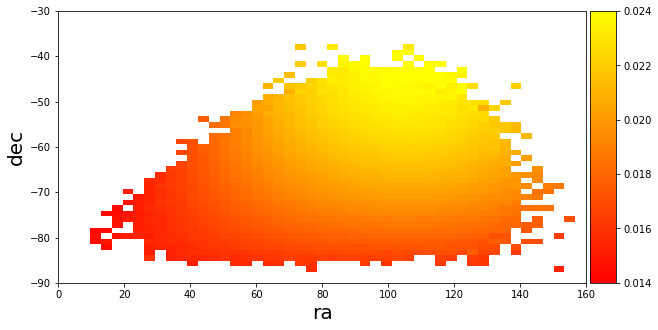

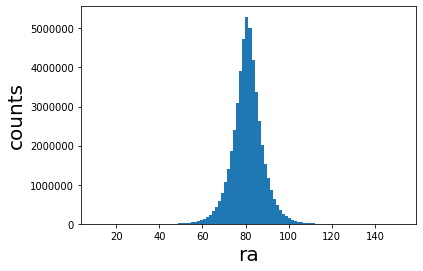

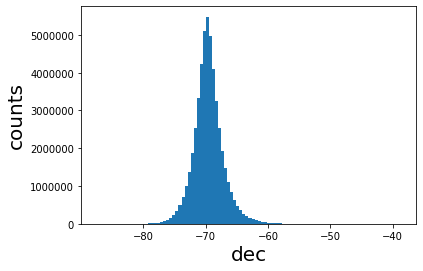

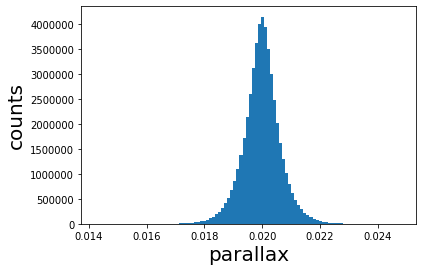

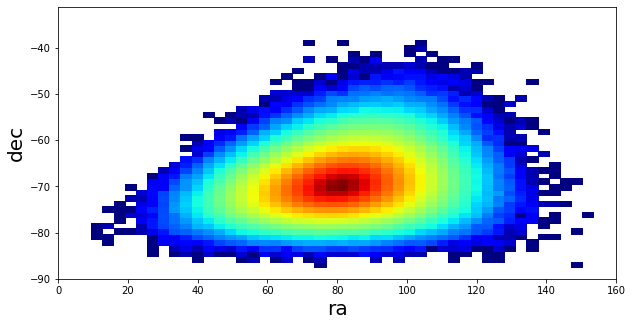

In [9]:
ra=simu1[:,0]
dec=simu1[:,1]
parallax=simu1[:,2]
print(ra,dec)
bins1=np.arange(0,160,160/50)
bins2=np.arange(-90,-30,60/50)
ret=stats.binned_statistic_2d(ra, dec, parallax, statistic='mean', bins=[bins1,bins2], range=None, expand_binnumbers=False)

mean1=ret.statistic

xedges=ret.x_edge

yedges=ret.y_edge

plt.figure(figsize=(10,5))
im=plt.imshow(mean1.T, aspect='auto',interpolation="nearest", origin="upper",cmap='autumn',extent=[0, 160, -30, -90],vmin=0.014,vmax=0.024)
ax = plt.gca()
ax.invert_yaxis()
#plt.gca().invert_xaxis()
plt.xlabel("ra",fontsize=20)
plt.ylabel("dec",fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

plt.hist(ra,bins=100)
plt.xlabel("ra",fontsize=20)
plt.ylabel("counts",fontsize=20)
plt.show()
plt.hist(dec,bins=100)
plt.xlabel("dec",fontsize=20)
plt.ylabel("counts",fontsize=20)
plt.show()
plt.hist(parallax,bins=100)
plt.xlabel("parallax",fontsize=20)
plt.ylabel("counts",fontsize=20)
plt.show()


plt.figure(figsize=(10,5))

plt.hist2d(ra,dec,bins=[bins1,bins2],cmap='jet',norm=LogNorm())
plt.xlim(0,160)
plt.xlabel("ra",fontsize=20)
plt.ylabel("dec",fontsize=20)
#plt.gca().invert_xaxis()
plt.show()

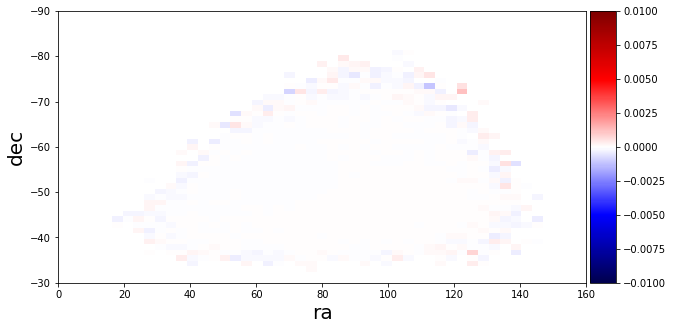

In [10]:
plt.figure(figsize=(10,5))
im=plt.imshow(mean1.T-meant.T, aspect='auto',interpolation="nearest", origin="upper",cmap='seismic',vmin=-0.010,vmax=+0.010,extent=[0, 160, -90, -30])
plt.xlabel("ra",fontsize=20)
plt.ylabel("dec",fontsize=20)
ax = plt.gca()
ax.invert_yaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

# Inferencia usando ABC


## Toy Example


We need to provide:

- a dataset
- a forwards simulating model for the data
- a method defining the distance metric

### Test 0

En este primer test usamos como "datos observacionales" la simulación que se ve en el plot de arriba. Con los parametros que venian impuestos por defecto y dist_centre_lmc=50

El test es muy sencillo. Simplemente he dejado como único parámetro libre el dist_centre_lmc y he mirado si lo recuperabamos. 

No ha habido sorpresas. Y hemos recuperado dist_centre_lmc=51.4

### astroABC for python

### Key features

-    Parallel sampling using MPI or multiprocessing
-    MPI communicator can be split so both the sampler, and simulation launched by each particle, can run in parallel

-    A Sequential Monte Carlo sampler (see e.g. Toni et al. 2009, Beaumont et al. 2009, Sisson & Fan 2010)

-    A method for iterative adapting tolerance levels using the qth quantile of the distance for t iterations (Turner & Van Zandt (2012))

-    Scikit-learn covariance matrix estimation using Ledoit-Wolf shrinkage for singular matrices

-    A module for specifying particle covariance using method proposed by Turner & Van Zandt (2012), optimal covariance matrix for a multivariate normal perturbation kernel, local covariance estimate using scikit-learn KDTree method for nearest neighbours (Filippi et al 2013) and a weighted covariance (Beaumont et al 2009)

-    Restart files output frequently so an interrupted run can be resumed at any iteration
-    Output and restart files are backed up every iteration
-    User defined distance metric and simulation methods
-    A class for specifying heterogeneous parameter priors
-    Methods for drawing from any non-standard prior PDF e.g using Planck/WMAP chains
-    A module for specifying a constant, linear, log or exponential tolerance level
-    Well-documented examples and sample scripts


In [11]:
import astroabc

# We define the function to perform the simulations

# We define the distance metric that we want to use

In [12]:
# Métrica de distáncia sencilla. Se puede cambiar cuando queramos.

def metric_asymetries(observed,simulated): # Function to compute the distance metric using Chi^2
    
   
    if simulated.size==1:
        mychisum=np.inf
    else:
        nanos=np.count_nonzero(np.isnan(simulated)) # Count the number of bins with nans
        lens=len(simulated)                      


        if nanos>0.99*lens:  # if more than 50% of the bins have nans assign distance=infinity
            mychisum=float('Inf')
        else:
            mychi=np.nansum(((observed-simulated)/sigma)**2) # Sum of all Chi^2 for each bin                  
            Nbin=abs(lens-nanos)                                 # Compute the number of bins without nans
            mychisum=np.sum(mychi)/Nbin                     # Normalization over the number of bins
    #print(mychisum)                       
    return mychisum

In [13]:
sigmam=np.ones((10,10))
sigma=np.reshape(sigmam,100)*0.001

Next we need to set some keywords for astroABC. This can be done by creating a dictionary of inputs which are passed to the sampler. Many of these entries have defaults and do not need to be specified explicitly.
Only the name of the distance metric method needs to be explicity provided as a keyword.
The full set of keywords are given in the doc string of the class. Some examples are

- tol_type: which specifies the decreasing tolerance levels. "exp","lin", "log" and "const" are options. (default = 'exp')

- verbose: level of verbosity, 0 = no printout to screen, 1 = print to screen  (default = 0)

- adapt_t: Boolean True/False for adaptive threshold setting (default = False)

- threshold: qth quantile used in adaptive threshold setting (default = 75)

- pert_kernel: 1 =component wise pert. with local diag variance; 2 = multivariate pert. based on local covariance

- variance_method: 0 =weighted covariance, 1= Filippi, 2 = TVZ, 3= Leodoit_Wolf, 4=k-nn (default = 0)

- dfunc:method for calculating the distance metric

- from_restart: Boolean True/False

- restart: string name of restart file

- outfile:string specifying name of output file (default = abc_out.txt)

- mpi: Boolean True/False (default = False)

- mp:Boolean True/False (default = False)

- num_proc:number of threads for mp setting (default = None)

Please see the doc strings of the astroABC sampler for details on each of these settings.

In [14]:
if __name__ == "__main__":
    prop={'tol_type':"exp","verbose":1,'adapt_t':True,'threshold':75,
        'pert_kernel':2,'variance_method':0, 'dfunc':metric_asymetries, 'restart':"restart_abc.txt", 'outfile':"abc_mpi.txt",'mpi':False,'mp':False,'num_proc':4,
        'from_restart':False}

Next we specify priors for each of the parameters we want to vary in the sampler. This is done by specifying a list of tuples. The zeroth element in each tuple should be a string specifying the prior for this parameter and the first element should be a list of the hyperparameters needed for this prior.

In [15]:
priors =  [('uniform', [5., 200.])] # Define the priors por the parameters to explore

## We fo for the main function

In [16]:
def main():
    param=[50]
    data=simu_LMC(param)
    sampler = astroabc.ABC_class(1,10,data,[1000,1],20,priors,**prop)
    model_sim=simu_LMC
    
    
    sampler.sample(model_sim)

Finally we run the main program

## A bit of theory

### Introduction to ABC

Approximate Bayesian computation
(ABC) and so called "likelihood free" Markov chain Monte Carlo techniques are popular methods
for tackling parameter inference in scenarios where the likelihood is intractable or unknown.
These methods are called likelihood free as they are free from any assumption about the form of the likelihood, as ABC aims to simulate samples from the parameter posterior distribution directly.
In traditional MCMC approaches the target distribution is the posterior distribution of interest and in practice our estimate of this pdf is approximate due to finite sampling time resulting in a correlated chain which we hope has converged.
ABC methods are also approximate in the sense that samples are generated from trial distributions which we hope are close to the real posterior of interest.
The [wikipedia]( https://en.wikipedia.org/wiki/Approximate_Bayesian_computation) page on ABC has a good introduction to the topic.

The simplest ABC algorithm is rejection sampling. 
Given a set of parameters, $\theta$, with associated priors, $\pi(\theta)$ and a forward simulated model for the data,

$\pi(D|\theta)$. 

We can simulate from the posterior distribution, $P(\theta|D)$, by first drawing sample parameters

$\theta^* \sim \pi(\theta)$, 

then simulating a dataset with these parameters 

$D^* \sim \pi(D|\theta^*)$.

In a simple rejection sampling algorithm, we reject $D^*$  unless it matches the true data, $D$.
For discrete data this algorithm would not be practical as many simulated samples would be rejected until an exact match is found.
In practice we make an approximation and accept simulated datasets which are "close" to the true data. This introduces the idea of a distance metric and tolerance level in ABC. We accept proposed parameters $\theta^*$, if 

$\rho(D^* - D) <\epsilon$

where $\rho$ is the distance metric, which could be e.g. the Euclidean norm $||D^* - D||$,  and $\epsilon$ is a tolerance threshold. This procedure produces samples from 

$P(\theta | \rho(D^*-D)<\epsilon)$ 

which will be a good approximation of the true posterior if $\epsilon$ is small.

The tolerance threshold in ABC controls which of the proposed parameters are accepted given the distance metric. There are two considerations in choosing this threshold. If the tolerance is too high then too many proposed parameters are accepted and the prior distribution dominates the results e.g. if the tolerance level is infinity then we would just recover the prior distribution from the algorithm. If the tolerance level is too low then the sampler is very inefficient with many proposed points being rejected.
A compromise is to select a set of decreasing tolerance levels where for the initial iterations in the algorithm we accept points in parameter space which do not represent the data with high accuracy but as the algorithm progresses the tolerance level decreases and our estimate of the true posterior distribution improves.

In many cases it may be simpler to work with some lower dimension summary statistic of the data, $S(D)$,
rather then the full dataset. In this case the chosen statistic needs to be a so-called *sufficient statistic* in that
any information about the parameter of interest which is contained in the data, is also contained in the summary statistic. More formally a statistic $S(D)$ is sufficient for $\theta$ if the distribution $P(D|S(D))$ does not depend on $\theta$.
This requirement ensures that in summarizing the data we have not thrown away constraining information about $\theta$.


### ABC Sequential Monte Carlo

Rather than drawing candiates $\theta^*$, one at a time, we can
speed up the ABC algorithm by working with large
pools of candidates, called particles, simultaneously. 
At each stage of the algorithm the particles are perturbed and filtered using the distance metric, and eventually
this pool of particles move closer and closer to simulating from the desired posterior distribution.
This approach is known as Sequential Monte Carlo or Particle Monte Carlo sampling.

Outline of the ABC SMC algorithm:

- At iteration 0, for each particle:
    1. Generate $\theta_i^* \sim \pi(\theta)$. 
    2. Simulate a dataset $D_i^* \sim \pi(D|\theta_i^*)$
    3. If  $\rho(S(D_i^*) - S(D))<\epsilon_0$ accept $\theta_i^*$ else go to 1.
- set $\theta_{i,0} = \theta_i^*$
- set weights for each particle $w_{i,0} = 1/N$
- evaluate the covariance amongst particles $\sigma^2_{1:N;0}$
- At iteration t>0, for each particle: 
    4. Sample random particle from previous iteration $\theta_i^* \sim \theta_{1:N;0}$ 
    5. Perturb $\theta_i^*$ by drawing $\theta_i^{**} \sim \mathcal{N}(\theta^*, \sigma^2_{t-1})$
    6. Simulate a dataset $D_i^* \sim \pi(D|\theta_i^{**})$
    7. If  $\rho(S(D_i^*) - S(D))<\epsilon_0$ accept $\theta_i^{**}$ else go to 4.
- set $\theta_{i,t} = \theta_i^{**}$
- set weights for each particle $w_{i,t}$ using a transition kernel
- evaluate the covariance amongst particles $\sigma^2_{1:N;t}$
    
Different ABC SMC algorithms can be distinguished
by how sampling weights are assigned to the particles in the pool.
In order to perturb and filter the particles we need a transition kernel. The transition
kernel serves the same purpose as the proposal distribution in a standard
MCMC algorithm. The transition kernel specifies the distribution of a random variable that will
be added to each particle to move it around in the parameter space.
For more details on this please see 
[Beaumont et al 2009]( https://arxiv.org/abs/0805.2256).

# Testing and Debugging the code

In [17]:
>>> a = np.array([[ 5, 1 ,3], 
                  [ 1, 1 ,1], 
                  [ 1, 2 ,1],[ 5, 1 ,3], 
                  [ 1, 1 ,1], 
                  [ 1, 2 ,1]])
>>> b = np.array([1, 2, 3])
c=a.dot(b)
>>> print (a.dot(b))


[16  6  8 16  6  8]


In [18]:
c.reshape(2,3)+b

array([[17,  8, 11],
       [17,  8, 11]])

In [19]:
c.shape

(6,)

In [20]:
a.shape

(6, 3)

In [21]:
b.shape

(3,)

In [22]:
####################################
### Generate synthetic catalogue ###
####################################

# LMC fixed hyperparameters
dist_centre_lmc=50. 
alpha_centre_lmc=80.8939*np.pi/180. 
delta_centre_lmc=-69.7561*np.pi/180.
pos_angle_lmc=(122.5 + 90.)*np.pi/180.
inc_angle_lmc=34.7*np.pi/180. 

# Disk component fixed hyperparameters
disk_scale_height = 0.35
disk_scale_length = 1.6
pos_angle_disk = 202.7*np.pi/180
ell_factor_disk = 0.688 

# Uncertainty on measurements roughly estimated from the catalogue
ra_error_mean   = 0.1711426
ra_error_var = 0.006506719

dec_error_mean    =  0.1804739
dec_error_var = 0.007289793 

plx_error_mean  =  0.1758596
plx_error_var = 0.006775405 


# Set No of samples we want to generate
N = 10000

## Testing disk_fn function

In [23]:
N = 100000

mat11 (100000, 3)


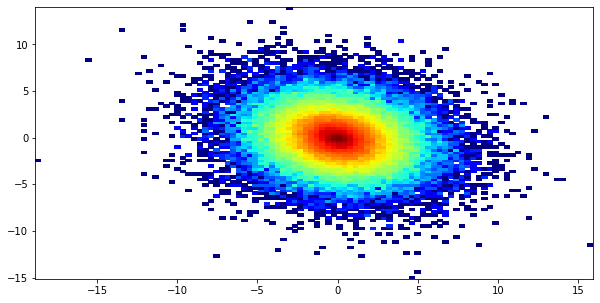

In [24]:
# Generate disk location coordinates in the LMC proper reference frame
xyz_propern = disk_fn(N, disk_scale_height, disk_scale_length, 
                     pos_angle_disk - pos_angle_lmc, ell_factor_disk)

# Transform from proper to heliocentric frame
xyz_geon =  proper2geo_fn(xyz_propern, dist_centre_lmc, alpha_centre_lmc,
                         delta_centre_lmc, pos_angle_lmc, inc_angle_lmc )

# Generate (ra,dec,plx) true values

cyl_plxn  =   geo2plx_fn(xyz_geon)

In [25]:
simulation=cyl_plxn

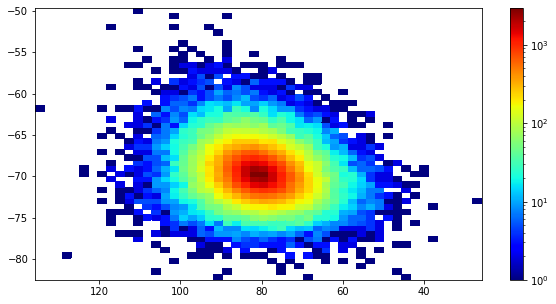

In [26]:
ra=simulation[:,0]
dec=simulation[:,1]
parallax=simulation[:,2]


from matplotlib.colors import LogNorm
plt.figure(figsize=(10,5))
plt.hist2d(ra,dec,50,cmap='jet',norm=LogNorm())
plt.gca().invert_xaxis()
plt.colorbar()
plt.show()

In [27]:
# Generate disk location coordinates in the LMC proper reference frame
xyz_propert = disk_fnt(N, disk_scale_height, disk_scale_length, 
                     pos_angle_disk - pos_angle_lmc, ell_factor_disk)

# Transform from proper to heliocentric frame
xyz_geot =  proper2geo_fnt(xyz_propert, dist_centre_lmc, alpha_centre_lmc,
                         delta_centre_lmc, pos_angle_lmc, inc_angle_lmc )

# Generate (ra,dec,plx) true values

cyl_plxt  =   geo2plx_fnt(xyz_geot)


In [28]:
simulation2=np.array(cyl_plxt)

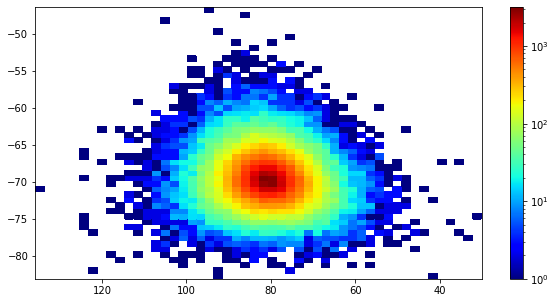

In [29]:
ra=simulation2[:,0]
dec=simulation2[:,1]
parallax=simulation2[:,2]


from matplotlib.colors import LogNorm
plt.figure(figsize=(10,5))
plt.hist2d(ra,dec,50,cmap='jet',norm=LogNorm())
plt.gca().invert_xaxis()
plt.colorbar()
plt.show()

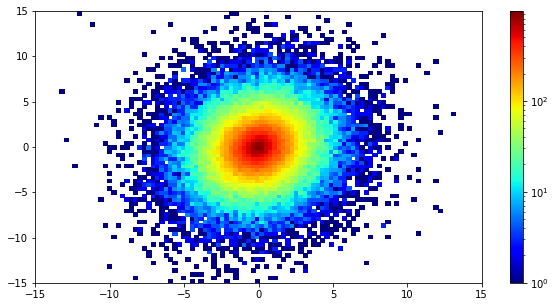

In [30]:
x=xyz_propert[:,0]
y=xyz_propert[:,1]
z=xyz_propert[:,2]


from matplotlib.colors import LogNorm
plt.figure(figsize=(10,5))
plt.hist2d(x,y,100,cmap='jet',norm=LogNorm())
plt.ylim(-15,15)
plt.xlim(-15,15)
plt.colorbar()
plt.show()

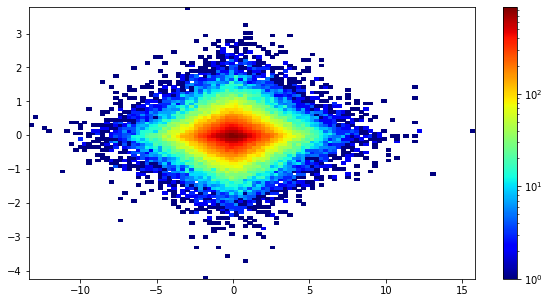

In [31]:
x=xyz_propert[:,0]
y=xyz_propert[:,1]
z=xyz_propert[:,2]



plt.figure(figsize=(10,5))
plt.hist2d(x,z,100,cmap='jet',norm=LogNorm())
plt.colorbar()
plt.show()

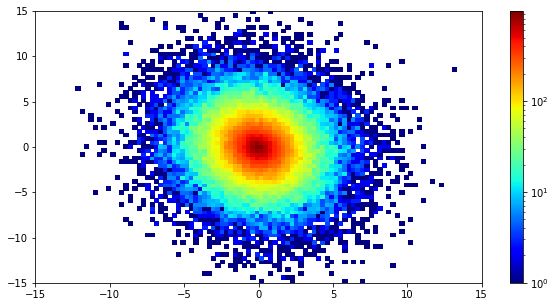

In [32]:
x=xyz_propern[:,0]
y=xyz_propern[:,1]
z=xyz_propern[:,2]



plt.figure(figsize=(10,5))
plt.hist2d(x,y,100,cmap='jet',norm=LogNorm())
plt.ylim(-15,15)
plt.xlim(-15,15)
plt.colorbar()
plt.show()

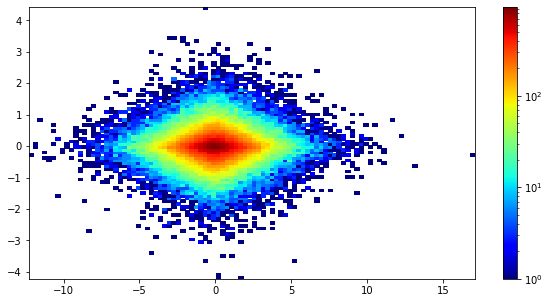

In [33]:
x=xyz_propern[:,0]
y=xyz_propern[:,1]
z=xyz_propern[:,2]



plt.figure(figsize=(10,5))
plt.hist2d(x,z,100,cmap='jet',norm=LogNorm())
plt.colorbar()
plt.show()

In [34]:
r1 = tfd.Gamma(concentration=2, rate=1/1.6).sample(100000000 )
r2 =np.random.gamma(shape = 2,scale = 1.6, size = 100000000)

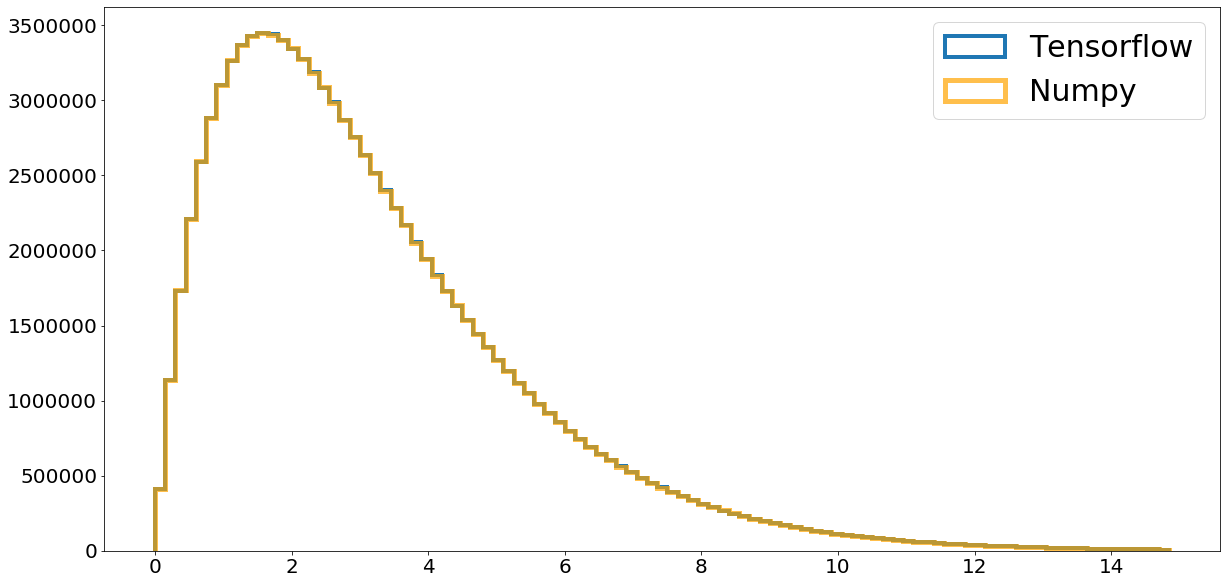

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
bins=np.arange(0,15,15/100)
plt.hist(r1,bins=bins,histtype="step",lw=4,label="Tensorflow")
plt.hist(r2,bins=bins,color="orange",alpha=0.7,histtype="step",lw=5,label="Numpy")
#plt.xlim(0,10)
plt.xticks(fontsize=20 )
plt.yticks(fontsize=20 )
plt.legend(fontsize=30)
plt.show()

In [36]:
z = tfd.Laplace(loc=0., scale=0.35).sample(100000000 )
z2 = np.random.laplace(loc=0., scale=0.35, size=100000000 )

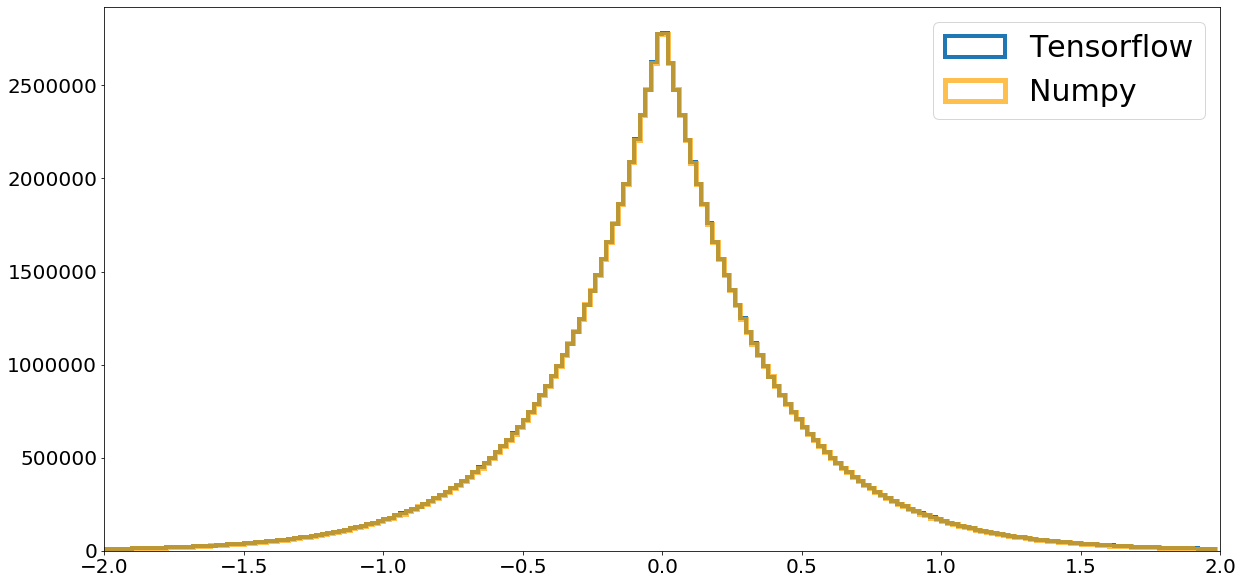

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
bins=np.arange(-2,2,1/50)
plt.figure(figsize=(20,10))
plt.hist(z,bins=bins,histtype="step",lw=4,label="Tensorflow")
plt.hist(z2,bins=bins,color="orange",alpha=0.7,histtype="step",lw=5,label="Numpy")
plt.xlim(-2,2)
plt.xticks(fontsize=20 )
plt.yticks(fontsize=20 )
plt.legend(fontsize=30)
plt.show()

In [38]:
theta = tfd.Uniform(low=0., high=2.*np.pi).sample(10000000)

theta2 = np.random.uniform(low=0., high=2.*np.pi, size = 10000000)

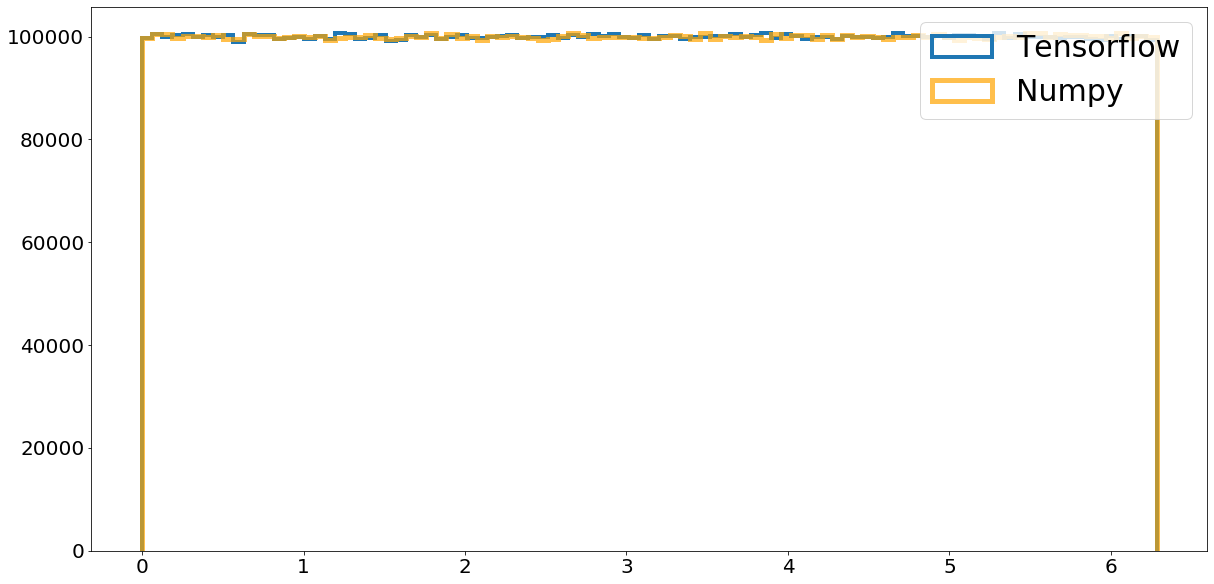

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.hist(theta,bins=100,histtype="step",lw=4,label="Tensorflow")
plt.hist(theta2,bins=100,color="orange",alpha=0.7,histtype="step",lw=5,label="Numpy")
#plt.xlim(-2,2)
plt.xticks(fontsize=20 )
plt.yticks(fontsize=20 )
plt.legend(fontsize=30)
plt.show()

In [40]:
psiAngle=pos_angle_disk - pos_angle_lmc

s11 =  np.cos(psiAngle) 
s12 = -np.sin(psiAngle)   
s13 = np.zeros([])
s21 =  np.sin(psiAngle)
s22 =  np.cos(psiAngle)  
s23 = np.zeros([])
s31 = np.zeros([])  
s32 = np.zeros([])  
s33 = np.ones([])

matrix = np.stack((s11,s12,s13,s21,s22,s23,s31,s32,s33),
                  axis=-1)  # pyformat: disable
output_shape = np.concatenate((
np.shape(np.zeros(4))[:-1], (3, 3)), axis=-1)

OXYZ6 = np.reshape(matrix, output_shape.astype(int))

print(OXYZ6)

[[ 0.9854079  0.1702095  0.       ]
 [-0.1702095  0.9854079  0.       ]
 [ 0.         0.         1.       ]]


mat11 [[ 1.67689575e+00 -8.30672731e-01  3.26696971e+00 ...  1.67250640e+00
  -4.50922668e-01 -5.46142338e-01]
 [ 4.75529790e+00  2.75430516e-01  3.50583189e+00 ... -5.09437917e-01
  -3.32718965e+00  1.27453946e-01]
 [-4.56445005e-01  7.91126443e-01 -2.32700147e-01 ... -3.51297480e-03
  -7.69462774e-01 -2.92369512e-01]]


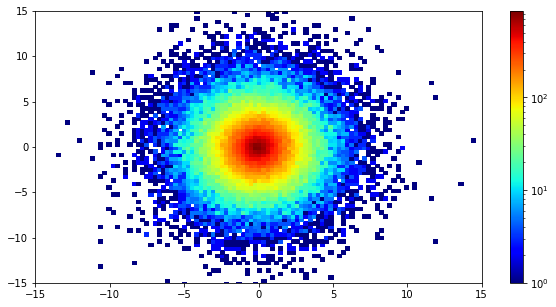

In [41]:
n=100000
ellFactor=0.688 
#r = tfd.Gamma(concentration=2, rate=1./scaleLength).sample(n )
r = np.random.gamma(shape = 2,scale = 1.6, size = n)
theta = np.random.uniform(low=0., high=2.*np.pi, size = n)

x = ellFactor * r * np.cos(theta)
y = r * np.sin(theta)

z = np.random.laplace(loc=0., scale=0.35, size=n )

#chain = tfb.Chain([  S3_ALO ])
output1n=OXYZ6.dot(np.stack([x,y,z],axis=1).T)
print("mat11",output1n)




plt.figure(figsize=(10,5))
plt.hist2d(x,y,100,cmap='jet',norm=LogNorm())
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.colorbar()
plt.show()



In [42]:
s11 =  tf.cos(psiAngle) 
s12 = -tf.sin(psiAngle)   
s13 = tf.zeros([])
s21 =  tf.sin(psiAngle)
s22 =  tf.cos(psiAngle)  
s23 = tf.zeros([])
s31 = tf.zeros([])  
s32 = tf.zeros([])  
s33 = tf.ones([])

matrix = tf.stack((s11,s12,s13,s21,s22,s23,s31,s32,s33),
                  axis=-1)  # pyformat: disable

output_shape = tf.concat((
    tf.shape(input=tf.zeros(4))[:-1], (3, 3)), axis=-1)

OXYZ6 = tf.reshape(matrix, shape=output_shape)

print(OXYZ6)

tf.Tensor(
[[ 0.9854079  0.1702095  0.       ]
 [-0.1702095  0.9854079  0.       ]
 [ 0.         0.         1.       ]], shape=(3, 3), dtype=float32)


In [43]:
S3_ = tf.linalg.LinearOperatorFullMatrix(OXYZ6)
print(S3_)
S3_ALO = tfb.AffineLinearOperator(shift=tf.zeros(3), scale=S3_)
print("Alo",S3_ALO)
r = tfd.Gamma(concentration=2, rate=1./1.6).sample(n )
theta = tfd.Uniform(low=0., high=2.*np.pi).sample(n )

x = ellFactor * r * tf.cos(theta)
y = r * tf.sin(theta)

z = tfd.Laplace(loc=0., scale=0.35).sample(n )

chain = tfb.Chain([  S3_ALO ])

output1= chain._forward(tf.stack([x, y, z], axis=1))
print("Shape",output1)

Alo <tensorflow_probability.python.bijectors.affine_linear_operator.AffineLinearOperator object at 0x7f4a1407ed10>
Shape tf.Tensor(
[[ 2.2352371   2.285992    0.03022837]
 [-0.10909986 -0.5571699  -0.02859182]
 [ 0.52921176 -2.381345   -0.03897832]
 ...
 [ 1.2428957  -0.64737755  0.49817345]
 [-0.12533632  0.40000167 -1.0938537 ]
 [-4.4648604  -1.5834383  -0.02785895]], shape=(100000, 3), dtype=float32)


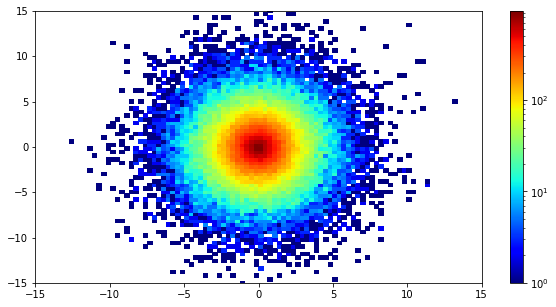

In [44]:
plt.figure(figsize=(10,5))
plt.hist2d(x,y,100,cmap='jet',norm=LogNorm())
plt.ylim(-15,15)
plt.xlim(-15,15)
plt.colorbar()
plt.show()

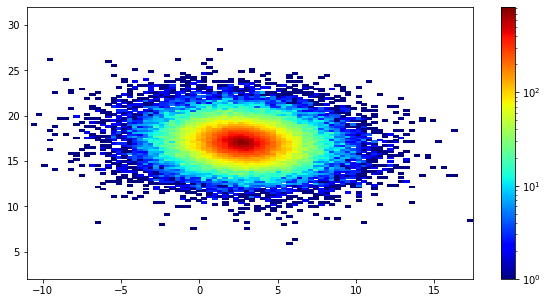

In [45]:

x=xyz_geon[:,0]
y=xyz_geon[:,1]
z=xyz_geon[:,2]

plt.figure(figsize=(10,5))
plt.hist2d(x,y,100,cmap='jet',norm=LogNorm())
plt.xlim(-11,17.5)
plt.ylim(2,32)
plt.colorbar()
plt.show()

In [46]:
x=xyz_geot[:,0]
y=xyz_geot[:,1]
z=xyz_geot[:,2]

  

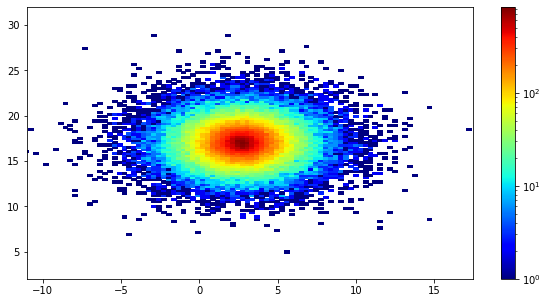

In [47]:
plt.figure(figsize=(10,5))
plt.hist2d(x,y,100,cmap='jet',norm=LogNorm())
plt.xlim(-11,17.5)
plt.ylim(2,32)
plt.colorbar()
plt.show() 

In [48]:
np.shape(mat1)

NameError: name 'mat1' is not defined

In [ ]:
print(mat1)

In [ ]:
x=mat1[:,0]
y=mat1[:,1]
z=mat1[:,2]


plt.figure(figsize=(10,5))
plt.hist2d(x,y,100,cmap='jet',norm=LogNorm())
#plt.xlim(-10,15)
#plt.ylim(10,24)
plt.show() 

In [ ]:
plt.hist(x,bins=100)
plt.hist(y,bins=100)